In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
set.seed(1)

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")
jHighSpeeds <- c("都市間高速", "都市高速", "有料道路")

In [4]:
jMoreParteds <- c("都市間高速", "国道")

In [5]:
printf <- function(...) cat(sprintf(...))

In [6]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'RoadType', 'PathType', 'flag')
isValidColumn <- function(x) ! x %in% invalids

In [7]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.0133)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        } else {
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [8]:
correctVsPredict <- function(test, predictedFlags, verbose=FALSE) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
        
    if (verbose) {
        printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
        printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)  
    }    
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [9]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [10]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Reds

In [11]:
df3 <- read.csv("../data/middle/sp3.csv", stringsAsFactors=FALSE)

In [12]:
colnames(df3)

[1] "Time"              "Longitude"         "Latitude"         
 [4] "Speed"             "Brake"             "Accel"            
 [7] "Engine"            "AheadDistance"     "Curve150"         
[10] "Curve100"          "Curve"             "SteeringAngle"    
[13] "BranchFlag"        "DistTollgate"      "RoadType"         
[16] "GreenLamp"         "RedLamp"           "RightLamp"        
[19] "UpLamp"            "LeftLamp"          "StopSign"         
[22] "Limit30Sign"       "Limit50Sign"       "BrakeCar"         
[25] "LeftCar"           "ManBicycleCount"   "ManBicycle"       
[28] "DistManBicycle"    "Pitch"             "DistSignal"       
[31] "PathType"          "LaneCount"         "AccelerationSpeed"
[34] "Jerk"              "AverageVelocity"   "MaxSpeed"         
[37] "MinSpeed"          "CurveAverage"      "flag"

In [13]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [14]:
allFeatures <- c(colnames(df3))

In [15]:
roadTypes <- unique(df3$RoadType)

In [16]:
for (i in roadTypes) {
    printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
    dfx <- df3[df3$RoadType == i, ]
    expr <- createFormula(invalids, allFeatures)
    result <- CV(dfx, expr, verbose=FALSE)
    printRedRatios(dfx)
    printf("Red: Mean correct/predict = %f\n", result[2])
    printf("Blue: Mean correct/predict = %f\n", result[3])
    printf("CV value: %f", result[1])
    printf("\n\n")
}

RoadType: 7 (その他)
Red/All = 25/27 = 0.925926
1 - Red/All = 2/27 = 0.074074
Red: Mean correct/predict = 0.933333
Blue: Mean correct/predict = NaN
CV value: 0.066667

RoadType: 6 (一般道1、一般道2、一般道3)
Red/All = 90/189 = 0.476190
1 - Red/All = 99/189 = 0.523810
Red: Mean correct/predict = 0.647497
Blue: Mean correct/predict = 0.632659
CV value: 0.375731

RoadType: 4 (県道)
Red/All = 36/71 = 0.507042
1 - Red/All = 35/71 = 0.492958
Red: Mean correct/predict = 0.573333
Blue: Mean correct/predict = 0.526667
CV value: 0.458929

RoadType: 5 (主要地方道)
Red/All = 154/303 = 0.508251
1 - Red/All = 149/303 = 0.491749
Red: Mean correct/predict = 0.547501
Blue: Mean correct/predict = 0.547146
CV value: 0.450860

RoadType: 3 (国道)
Red/All = 202/324 = 0.623457
1 - Red/All = 122/324 = 0.376543
Red: Mean correct/predict = 0.686459
Blue: Mean correct/predict = 0.479924
CV value: 0.385511

RoadType: 0 (都市間高速)
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
Red: Mean correct/predict = 0.636548
Blue: Mean corr

In [17]:
fit3 <- rpart(expr, data=df3, method="class")

In [18]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.0311804

In [19]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
[1] AheadDistance Curve         Curve100      Curve150      Engine       
[6] MaxSpeed      Pitch         Speed        

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.046771      0   1.00000 1.00000 0.035602
2 0.031180      3   0.85078 0.89978 0.035028
3 0.026726      4   0.81960 0.90200 0.035044
4 0.015590      5   0.79287 0.91759 0.035151
5 0.013363      6   0.77728 0.95546 0.035382
6 0.011136      9   0.73497 0.95768 0.035394
7 0.010000     11   0.71269 0.97996 0.035509


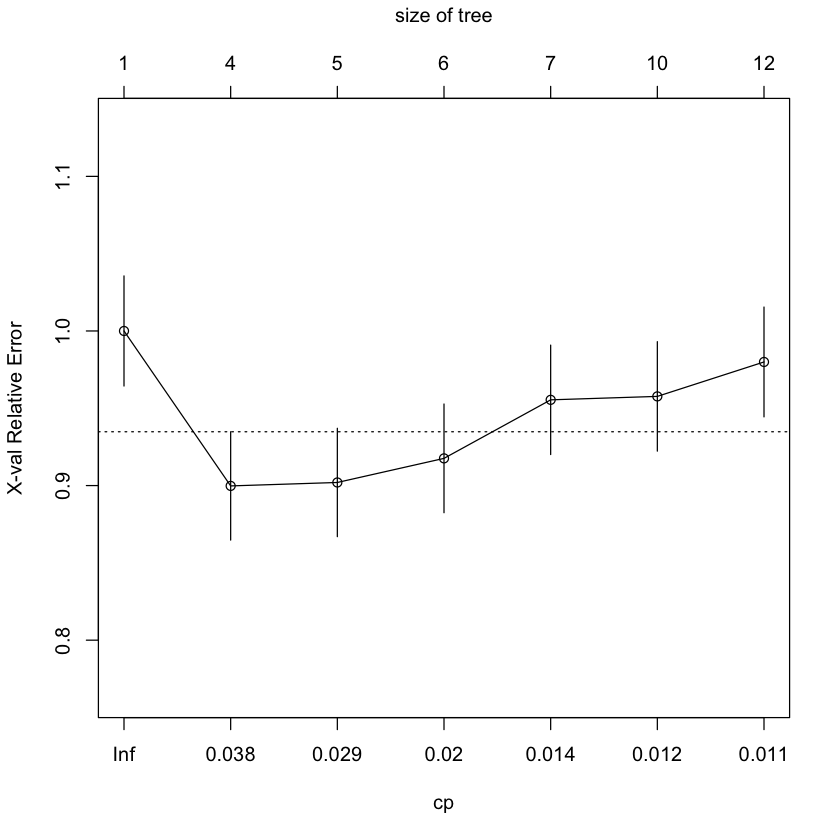

In [20]:
plotcp(fit3)

In [21]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.04677060      0 1.0000000 1.0000000 0.03560167
2 0.03118040      3 0.8507795 0.8997773 0.03502844
3 0.02672606      4 0.8195991 0.9020045 0.03504427
4 0.01559020      5 0.7928731 0.9175947 0.03515108
5 0.01336303      6 0.7772829 0.9554566 0.03538170
6 0.01113586      9 0.7349666 0.9576837 0.03539401
7 0.01000000     11 0.7126949 0.9799555 0.03550949

Variable importance
       MaxSpeed           Speed           Curve    CurveAverage        Curve100 
             17              14              11              10              10 
  AheadDistance        Curve150 AverageVelocity          Engine        MinSpeed 
             10               8               8               5               2 
          Pitch       LaneCount   SteeringAngle 
              2               1               1 

Node number 1: 1042 observations,    complexity param=0.0467706
  predicted cl

In [112]:
set.seed(1)

In [113]:
i = 0
threshold <- 50
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 0 (都市間高速)
Fold1
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Fold2
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 0/0 = NaN

Fold3
As for Red: correct/predict = 1/3 = 0.333333
As for Blue: correct/predict = 0/1 = 0.000000

Fold4
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/1 = 0.000000

Fold5
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 1/1 = 1.000000

Fold6
As for Red: correct/predict = 1/1 = 1.000000
As for Blue: correct/predict = 1/2 = 0.500000

Fold7
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 1/1 = 1.000000

Fold8
As for Red: correct/predict = 3/3 = 1.000000
As for Blue: correct/predict = 1/1 = 1.000000

Fold9
As for Red: correct/predict = 1/1 = 1.000000
As for Blue: correct/predict = 1/2 = 0.500000

Fold10
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 0/0 = NaN

AverageVelocit

In [103]:
set.seed(1)

In [114]:
i = 3
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 3 (国道)
Fold1
As for Red: correct/predict = 3/3 = 1.000000
As for Blue: correct/predict = 2/2 = 1.000000

Fold2
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/1 = 0.000000

Fold3
As for Red: correct/predict = 2/2 = 1.000000
As for Blue: correct/predict = 1/3 = 0.333333

Fold4
As for Red: correct/predict = 2/2 = 1.000000
As for Blue: correct/predict = 1/2 = 0.500000

Fold5
As for Red: correct/predict = 2/2 = 1.000000
As for Blue: correct/predict = 2/3 = 0.666667

Fold6
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/1 = 0.000000

Fold7
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 1/2 = 0.500000

Fold8
As for Red: correct/predict = 1/2 = 0.500000
As for Blue: correct/predict = 1/3 = 0.333333

Fold9
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 0/1 = 0.000000

Fold10
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Average